# Tutorial 3: A one-asset HANK model

In this notebook we solve the one-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)).

New concepts:
- **Hetinputs and hetoutputs**: adapt off-the-shelf HA blocks to new macro models.
- **Calibration DAG**: exploit analytical part of internal calibration 

For more examples and information on the SSJ toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules

## 1 Model description

The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. The model can be summarized in sequence form as

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{X} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs** and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 2 Embed HA block

As we have seen in the Krusell-Smith notebook, the main task in setting up HA blocks is to write a backward iteration function that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem with endogenous labor supply we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.

Solving the endogenous-labor problem via EGM is standard but somewhat tedious and so the details are left to ``sequence_jacobian/hetblocks/hh_labor.py``. Instead we will focus on how to adapt this off-the-shelf HetBlock to our specific macro enviroment.

In [23]:
hh = hetblocks.hh_labor.hh

print(hh)
print(f'Inputs: {hh.inputs}')
print(f'Macro outputs: {hh.outputs}')
print(f'Micro outputs: {hh.internals}')

<HetBlock 'hh'>
Inputs: ['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']


The HetBlock `hh` corresponds to the general problem:

$$
\begin{align} \tag{HH-general}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e\right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t(e) n + T_t(e)
\\
a &\geq 0
\end{align}
$$

That is, households take as given the sequence of interest rates $r_t$, and skill-specific wages $w_t(e)$ and  transfers $T_t(e).$ In the context of this particular HANK model, transfers equal dividends minus taxes. But it's easy to imagine many other cases. Rather than writing a specific backward iteration function for each of them, we can just supply a function that specifies how the $\{w_t(e), T_t(e)\}$ are determined in this particular case. We refer such functions as **hetinput**. 

In addition, we need to report effective labor supply $ne = n\cdot e$ to resolve labor market clearing. We can do so by attaching a **hetoutput** function to the core HetBlock. 

### 2.1 Hetinputs

Let's start with the hetinputs. These functions will be evaluated before the core HetBlock (i.e. the backward iteration).

In [24]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid


def transfers(pi_e, Div, Tax, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

def wages(w, e_grid):
    we = w * e_grid
    return we

- The second hetinput `transfers` takes inputs (`e_grid` and `pi_e`) that are produced by the first hetinput `make_grid`. Such *acylic* dependence between hetinputs is allowed. The block processes the inputs and outputs of the hetinput functions and puts them in a correct order of evaluation.
- Scalar-valued inputs of hetinputs may be time-varying. For example, aggregate dividends and taxes (`Div` and `Tax`) are determined endogenously in the HANK model and passed on to Bellman equation through the hetinput `transfers`. Thus, we can compute Jacobians with respect to them.

Let's attach these hetinputs to the household block using (the aptly-named) ``HetBlock.add_hetinput`` method.


In [25]:
hh1 = hh.add_hetinputs([make_grid, transfers, wages])

print(hh1)
print(f'Inputs: {hh1.inputs}')

<HetBlock 'hh' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Tax', 'w']


Note that `hh1` has only scalar-valued inputs.

### 2.2 Hetoutputs

Hetoutput functions are analogous to hetinputs. They are called after the backward iteration has converged. Thus, they may take multidimensional outputs of the backward iteration function as well as of the hetinputs as inputs.

In [26]:
def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

Let's attach this hetoutput to the household block using ``HetBlock.add_hetoutput`` method.

In [27]:
hh_ext = hh1.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')

<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']


- The signature of HetBlock `hh_ext` now references both hetinputs and hetoutputs.
- Aggregate outputs now include effective labor supply `NE`. 

### 2.3 Taking stock

The SSJ toolkit comes with 3 generic HetBlocks, located in `sequence_jacobian/hetblocks`.
- `hh_sim`: standard incomplete markets model
- `hh_labor`: standard incomplete markets model with frictionless labor supply
- `hh_twoasset`: two-asset model with convex portfolio adjustment cost

By using hetinputs and hetoutputs, these core blocks may be embedded in different macro environments. This is the simplest way of using the SSJ toolkit, which may suffice for many applications.

If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider. 
1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free. 
2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of `JacobianDict` (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (`impulse_linear`, `jacobian` and their `solved_` versions) at the macro model level.  



## 3 Calibrating the steady state
Similarly to the RBC example, we calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit a target for the interest rate and effective labor $L=1.$ Additionally we calibrate the wage $w$ such that the Phillips curve relation is satisfied in steady state for zero inflation $\pi=0$.

Note that the mapping from $\beta$ to asset market clearing given $r$ and that from $\varphi$ to average effective labor supply involve the household block. As such, we must rely on numerical root-finding. In contrast, the $w$ is easy to characterize analytically from the ss-version of NKPC:
$$
w = \frac{Z}{\mu} \tag{ss wage}
$$
This situation is very common in HA-DSGE models. Although using a numerical root-finder on every unknown jointly is likely to succeed in simple models, exploiting analytical solutions becomes crucial in more complicated models.

The simplest way of doing so is to work with two DAGs: one for calibration and one for transition dynamics. Typically, the two DAGs share some, but not all of their blocks. Furthermore, they may have different unknowns and targets. 

### 3.1 Blocks for SS-DAG

We already implemented the household block. Let's define the rest as simple blocks.

In [28]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

- These blocks---with the exception of `nkpc_ss`--- are valid in transition as well as in steady state. 
- Notice that we wrap `np.log()` in an `.apply()` inside simple blocks. This is necessary for functions whose name includes a dot. The reason is that it would interfere with some internal processing that simple blocks do to handle leads, lags, and references to steady state.  

In [29]:
blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'B']


Print inputs so we don't have to remember everything.

In [30]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0.0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'B': 5.6}

unknowns_ss = {'beta': 0.986, 'vphi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

Let's see the targets and Walras's law.

In [31]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  1.95e-14
Labor market clearing:  1.78e-15
Goods market clearing (untargeted): -5.26e-09


Looks good. Let's also plot the labor supply policy as function of assets for each skill type. We see that poorer and more productive households choose to work more. 

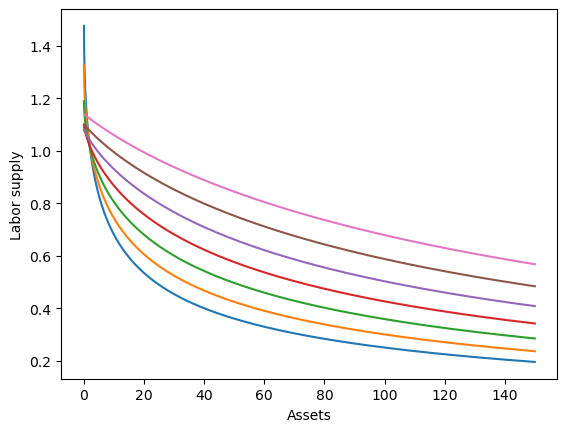

In [32]:
plt.plot(ss0.internals['hh']['a_grid'], ss0.internals['hh']['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

## 4 Linearized dynamics using Jacobians
Recall that we reduced the model to an implicit equation
$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

to be solved for $U=(\pi, w, Y)$ given any $Z=(Z, r^*)$. The rest of the endogenous variables are be obtained as explicit functions of $(\pi, w, Y; Z, r^*)$ along the DAG, but it would be tedious to write them out.

Keep in mind that the implicit function theorem implies that the response of unknowns is

$$
dU = \underbrace{-H_U^{-1}H_Z}_{G_U} dZ \tag{1}
$$

Recall that we already solved for a steady state and stored is as `ss`. Furthermore, we will use a 300-period truncation horizon. 

### 4.1 Set up the DAG

Let's set up the second (main) DAG. We just have to replace `nkpc_ss` with a full Phillips curve.

In [33]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'firm'>
<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'mkt_clearing'>


- Recall that `create_model` performs a topological sort to put the blocks in a (not necessarily unique) correct order of evaluation. Here, `monetary` must be first, then `nkpc`, `fiscal`, `firm` in any order, then `hh`, and finally `mkt_clearing`. Note that `hank.blocks` is a list in such an order.

Before we proceed, let's make sure that `ss0` is consistent with the second DAG. Just evaluate the `hank` at `ss0` and verify that the equilibrium conditions hold as expected.

In [34]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

### 4.2 Obtain GE Jacobian 

With the model object `hank` in hand, we can get the general equilibrium Jacobians by using its `solve_jacobian` method.

In [35]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z']>


Under the hood, the `solve_jacobian` method performs the following steps:
 - computes the partial Jacobians $\mathcal{J}^{o,i}$ for all blocks (if their Jacobian is not supplied already), only with respect to the inputs that actually change: unknowns, exogenous shocks, outputs of earlier blocks
 - forward accumulates partial Jacobians $\mathcal{J}^{o,i}$ to form total Jacobians $\mathbf{J}^{o,i}$
 - packs $\mathbf{J}^{o,i}$ to form $\mathbf{H_U}$ and $\mathbf{H_Z}$
 - solves for the GE Jacobians for unknowns $\mathbf{G_U} = \mathbf{H_U}^{-1}\mathbf{H_Z}$
 - forward accumulates GE Jacobians to obtain $\mathbf{G}$ for other endogenous variables 

### 4.3 Results

Now let's consider 25 basis point monetary policy shocks with different persistences and plot the response of inflation.

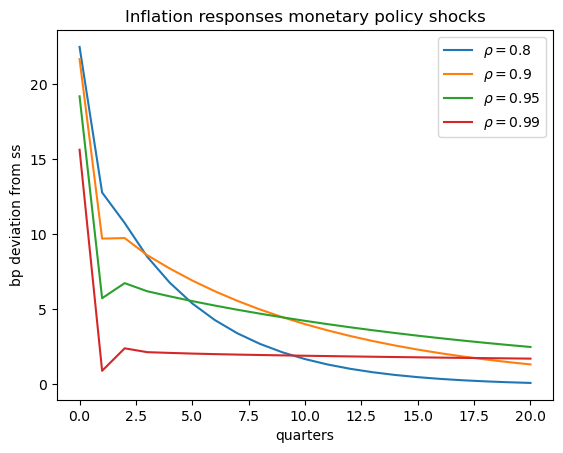

In [36]:
# rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
rhos = np.array([0.8, 0.9, 0.95, 0.99])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
dy = G['Y']['rstar'] @ drstar

# plt.plot(10000 * dpi[:21])
plt.plot(10000 * dy[:21])
plt.title(r'Inflation responses monetary policy shocks')
plt.legend([f'$\\rho = {rho}$' for rho in rhos])
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

## 5. Nonlinear dynamics
Conceptually there's nothing new in this section compared to the Krusell-Smith notebook. We're going to implement a quasi-Newton algorithm to solve for the unknown sequences $U=(\pi, w, Y)$ given some sequences of shocks $(r^*, Z).$ We initialize the algorithm by the naive guess that the variables in $U$ stay constant at their steady-state level. Then we evaluate the DAG and update the guess using the inverse Jacobian $H_U^{-1}.$ The algorithm converges in a few steps, despite the presence of substantial nonlinearities.

### 5.1 A typical monetary policy shock
Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size and persistence, this does not really matter.   

Solving One-Asset HANK for ['pi', 'w', 'Y'] to hit ['nkpc_res', 'asset_mkt', 'labor_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 5.77E-02
   max error for labor_mkt is 1.09E-02
On iteration 1
   max error for nkpc_res is 1.79E-05
   max error for asset_mkt is 2.11E-03
   max error for labor_mkt is 7.48E-05
On iteration 2
   max error for nkpc_res is 2.09E-06
   max error for asset_mkt is 1.39E-04
   max error for labor_mkt is 7.62E-05
On iteration 3
   max error for nkpc_res is 2.70E-07
   max error for asset_mkt is 1.00E-05
   max error for labor_mkt is 5.95E-06
On iteration 4
   max error for nkpc_res is 4.35E-08
   max error for asset_mkt is 1.65E-06
   max error for labor_mkt is 7.63E-07
On iteration 5
   max error for nkpc_res is 4.26E-09
   max error for asset_mkt is 1.08E-07
   max error for labor_mkt is 9.35E-08
On iteration 6
   max error for nkpc_res is 4.22E-10
   max error for asset_mkt is 1.68E-08
   max error for labor_mkt is 8.

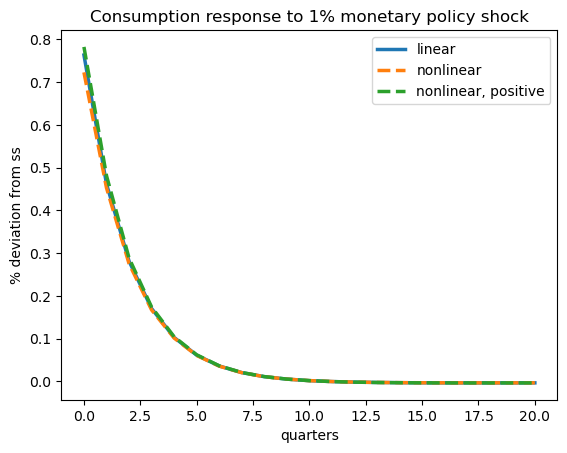

In [42]:
rho_r, sig_r = 0.61, -0.01
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path)
td_nonlin_pos = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"rstar": -sig_r * rho_r ** (np.arange(T))})
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

dC_nonlin = 100 * td_nonlin['C']
dC_nonlin_pos = 100 * td_nonlin_pos['C']
dC_lin = 100 * td_lin['C']

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.plot(-dC_nonlin_pos[:21], label='nonlinear, positive', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

### 5.2 A very large monetary policy shock
However, the nonlinearities may become substantial for very large or persistent monetary policy shocks. Reassuringly, the Jacobian still works well as an updating rule. The quasi-Newton method for a 10% monetary policy shock (extremely large!) still converges below in just 9 iterations, despite nonlinearities evident in the results.

Solving One-Asset HANK for ['pi', 'w', 'Y'] to hit ['nkpc_res', 'asset_mkt', 'labor_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.41E-01
   max error for labor_mkt is 2.68E-02
On iteration 1
   max error for nkpc_res is 9.66E-05
   max error for asset_mkt is 1.30E-02
   max error for labor_mkt is 5.55E-04
On iteration 2
   max error for nkpc_res is 2.62E-05
   max error for asset_mkt is 2.19E-03
   max error for labor_mkt is 7.31E-04
On iteration 3
   max error for nkpc_res is 3.84E-06
   max error for asset_mkt is 3.80E-04
   max error for labor_mkt is 9.03E-05
On iteration 4
   max error for nkpc_res is 1.50E-06
   max error for asset_mkt is 6.39E-05
   max error for labor_mkt is 1.83E-05
On iteration 5
   max error for nkpc_res is 1.26E-07
   max error for asset_mkt is 1.05E-05
   max error for labor_mkt is 2.52E-06
On iteration 6
   max error for nkpc_res is 3.47E-08
   max error for asset_mkt is 1.72E-06
   max error for labor_mkt is 4.

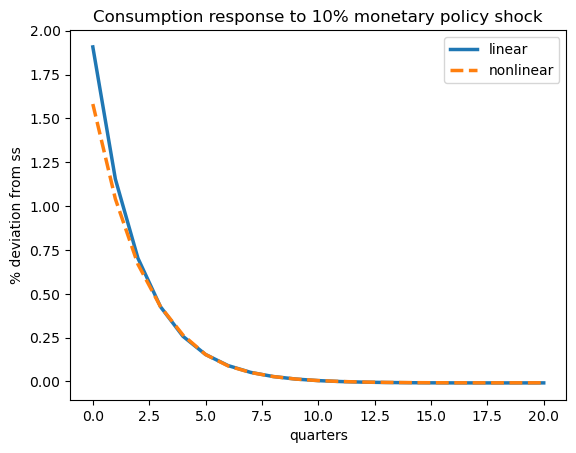

In [38]:
rho_r, sig_r = 0.61, -0.10/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path)
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

dC_nonlin = 100 * td_nonlin['C']
dC_lin = 100 * td_lin['C']

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 10% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

# Deleverage shock

In [39]:
rho_amin, sig_amin = 0.6, 0.1
amin_shock_path = {"amin": sig_amin * rho_amin ** (np.arange(T))}

# td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, amin_shock_path)
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, amin_shock_path)

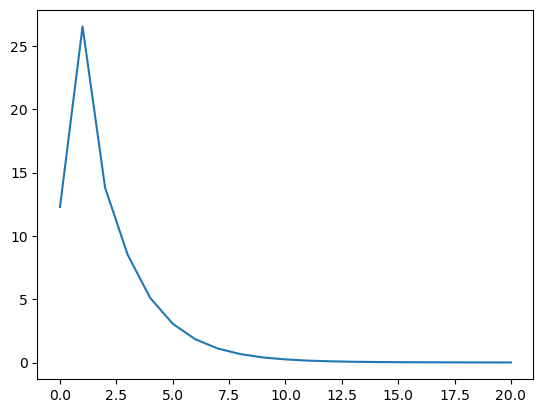

In [40]:
# plt.plot(amin_shock_path['amin'][:21])
plt.plot(100 * td_lin['C'][:21])